In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/distance/Distance_Matrix.csv
/kaggle/input/biomass/Biomass_History.csv
/kaggle/input/biomass-data/biomass.csv


In [2]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install keras-rl2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.9 MB/s eta 0:00:00


In [3]:
import plotly.express as px
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanSquaredLogarithmicError,MeanSquaredError,MeanAbsoluteError
from matplotlib import pyplot as plt
from shapely.geometry import Point, MultiPoint
import rtree
from sklearn.neighbors import NearestNeighbors
from gym import Env
from gym.spaces import Box, MultiDiscrete, Dict,Discrete
from shapely.ops import nearest_points
import geopandas as gpd
import seaborn as sns
import random
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
import bisect
import copy
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
biomass = pd.read_csv("/kaggle/input/biomass/Biomass_History.csv")
distance = pd.read_csv("/kaggle/input/distance/Distance_Matrix.csv")
# creating point objects, will be useful later on 
points = []
for i, row in biomass.iterrows():
    points.append((float(row['Longitude']),float(row["Latitude"])) )

biomass["Geometries"] = points
biomass["Type"] = "Biomass prod.plants"
print(biomass.head())


   Index  Latitude  Longitude       2010       2011       2012       2013  \
0      0  24.66818   71.33144   8.475744   8.868568   9.202181   6.023070   
1      1  24.66818   71.41106  24.029778  28.551348  25.866415  21.634459   
2      2  24.66818   71.49069  44.831635  66.111168  56.982258  53.003735   
3      3  24.66818   71.57031  59.974419  80.821304  78.956543  63.160561   
4      4  24.66818   71.64994  14.653370  19.327524  21.928144  17.899586   

        2014       2015       2016        2017            Geometries  \
0  10.788374   6.647325   7.387925    5.180296  (71.33144, 24.66818)   
1  34.419411  27.361908  40.431847   42.126945  (71.41106, 24.66818)   
2  70.917908  42.517117  59.181629   73.203232  (71.49069, 24.66818)   
3  93.513924  70.203171  74.536720  101.067352  (71.57031, 24.66818)   
4  19.534035  19.165791  16.531315   26.086885  (71.64994, 24.66818)   

                  Type  
0  Biomass prod.plants  
1  Biomass prod.plants  
2  Biomass prod.plants  
3  B

/tmp/ipykernel_32/1850315607.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(biomass.corr(), annot=True)


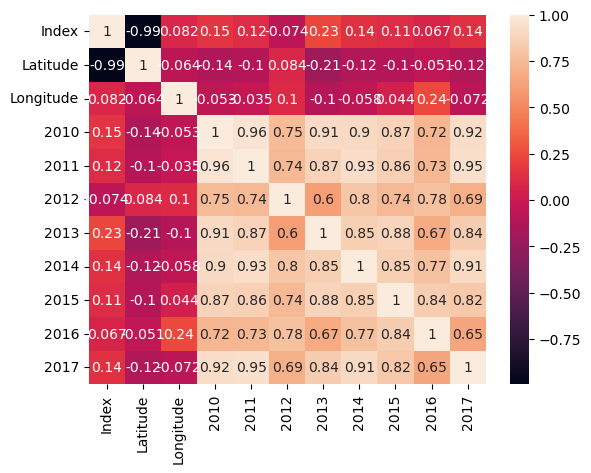

In [9]:
sns.heatmap(biomass.corr(), annot=True)
plt.show()

In [8]:
fig = px.scatter_mapbox(biomass, lat="Latitude", lon="Longitude",hover_data=["Index"],
                        color="2017", zoom=3, height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show(renderer='iframe')

In [ ]:
#predictions using neural networks

""" First a little data prep. We need to batch the results from 2010 till 2016, the 2017 
results will serve as the target values for the neural network"""

x = biomass[[str(i+2000) for i in range(10,17)]].values
print(x.shape)
y = biomass["2017"].values
print(y.shape)
scaler = StandardScaler()
x = scaler.fit_transform(x)
X_train,X_test,Y_train,Y_test = train_test_split(x,y, test_size = 0.25, random_state = 32)
print (X_train.shape, X_test.shape)


def build_net_no_dropout(input_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(input_size,activation = 'relu'))
    model.add(tf.keras.layers.Dense(128, activation = "relu"))
    model.add(tf.keras.layers.Dense(32, activation = "relu"))
    model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    return model


def build_net_with_dropout(input_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(input_size,activation = 'relu',kernel_regularizer = tf.keras.regularizers.L1(0.01)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(128, activation = "relu",kernel_regularizer = tf.keras.regularizers.L1(0.01)))
    model.add(tf.keras.layers.Dropout(0.7))
    model.add(tf.keras.layers.Dense(32, activation = "relu",kernel_regularizer = tf.keras.regularizers.L1(0.01)))
    model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    return model

def model_run(model,train_x,val_y, train_y, val_x, num_epochs):
    loss = MeanSquaredLogarithmicError()
    optimizer = "adam"
    model.compile( loss= loss, optimizer = optimizer, metrics = ["msle"])
    #training
    history = model.fit(train_x,train_y, epochs = num_epochs,batch_size= 70, verbose = 1,validation_data = (val_x,val_y))
    return history

def plotter(history,metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric,'val_'+metric])
    plt.show()
    



In [ ]:
#putting it all together

ann_without = build_net_no_dropout(X_train.shape[1])
hist_ann_without = model_run(ann_without,X_train,Y_test,Y_train,X_test,30)
plotter(hist_ann_without, "msle")
plotter(hist_ann_without, "loss")


In [ ]:
ann_with = build_net_with_dropout(X_train.shape[1])
hist_ann_with = model_run(ann_with,X_train,Y_test,Y_train,X_test,40)
plotter(hist_ann_with, "msle")
plotter(hist_ann_with, "loss")

In [ ]:

Predictions = ann_without.predict(X_test)
Real = Y_test
dft = pd.DataFrame({"real_2017":list(Y_test),"Prediction_2017":list(Predictions)})
plt.figure(figsize =(20,4))
plt.plot(dft["real_2017"])
plt.plot(dft["Prediction_2017"])
plt.legend(["Real", "Predictions"])
plt.show()

In [5]:
# each additional component in the waste to energy supply chain will be represented 

class Component():
    def __init__(self, index, name, num, cap,k,pointx,refinery, data=biomass.copy(),distance = distance.copy(),spare =points.copy(),sources=None):
        self.name = name
        self.index = index
        self.num = num       
        self.capacity = cap
        self.is_ref = refinery
        self.tree = rtree.index.Rtree()
        self.point = spare[index]
        
        self.pointx = copy.deepcopy(pointx)
            
    
        if refinery==True and sources!=  None:
            self.depot_left = sources.copy()
            for i,a in enumerate(sources):# sources should be index numbers
                p=spare[a]
                self.tree.insert(i,p+p,p)
                
        else:
            for i,p in enumerate(self.pointx):
                self.tree.insert(i,p+p,p)
            
       
        #print(len(self.pointx)) 
        
        # k nearest point
        self.sources= list(self.tree.nearest(self.point, k+1,objects='raw' ))
        if len(self.sources)>k+1:
            self.sources = self.sources[:k+1]
        
        self.sources = self.sources.copy()[1:]      
        #print(len(self.sources))
        self.sources_index = []
        if self.is_ref ==False:
            for i in self.sources:
                self.sources_index.append(spare.index(i))
            
        else: 
            for i in self.sources:
                self.sources_index.append(spare.index(i))
               
            
        #print("Original number of sources {}".format(len(self.sources)))
        
        #this part calculates the total output of the sources
        if self.is_ref==False:
            sources_output = data["2017"][self.sources_index].sum()
        
            self.under_util = 0
            if sources_output>self.capacity and self.is_ref == False:
                while True:
                    lee = data["2017"][self.sources_index].values
                    minx = np.argmin(lee, axis = 0)
                    self.sources.pop(minx)
                    self.sources_index.pop(minx)
                    sources_output = data["2017"][self.sources_index].sum()
                
                    if sources_output<=self.capacity:
                        self.under_util = self.capacity-sources_output
                        break
                    else:
                        continue
                
            if self.is_ref==False:    
                for i in self.sources:
                    self.pointx.remove(i)
                
            
                
            #print(len(self.pointx))        
            self.sources_output = sources_output 
        
         
    
        
        self.sources_index = [spare.index(i) for i in self.sources.copy()]
        self.total_dist = 0
        for i in self.sources_index:
            self.total_dist+=distance.iloc[i,self.index]
        
        #print("final number of sources {}".format(len(self.sources)))
        
    def prevent_duplicates(self):
        if self.is_ref ==True:
            depot_left = self.depot_left
            for iw in self.sources_index:
                depot_left.remove(iw)
            del(self.depot_left)
            return self.pointx,depot_left
        else:
            return self.pointx
            
    def add(self,df):
        q= int(self.index)
        df.Type[q] = str(self.name)
        return df
    def output(self):
        return self.sources_output
    def cost(self):
        if self.is_ref ==True:
            return self.total_dist
        else:
            return self.total_dist,self.under_util
    
            
        
        

def make_refinery(number,name, k, cap,depots,pointx,index=-1,refinery=True, allx=points.copy()):
    
    refineries = [] 
    if index==-1:        
        listr = [] 
        
        for i in range(number):
            index = allx.index(random.choice(pointx))
            
            if index not in listr :
                pointx.remove(allx[index])
                
                #print("current avail dept: {}".format(depots))
                comp = Component(index,name,i,cap,k,copy.deepcopy(pointx),refinery = refinery,sources=copy.deepcopy(depots))
                pointx,depots= comp.prevent_duplicates()
                refineries.append(comp)
                listr.append(index)
                
            else:
                i = i-1
                continue
    print("done")
    return  copy.deepcopy(refineries),copy.deepcopy(depots),copy.deepcopy(pointx)   

def make_components(number,name, k, cap,pointx,index=-1,refinery=False, allx = points.copy()):
    components = [] 
    if index==-1:        
        listr = [] 
        for i in range(number):
            index = allx.index(random.choice(pointx))
            if index not in listr:
                #print (pointx)
                pointx.remove(allx[index])
                comp = Component(index,name,i,cap,k,copy.deepcopy(pointx),refinery = refinery)
                pointx= comp.prevent_duplicates()
                components.append(comp)
                listr.append(index)
                
            else:
                i = i-1
                continue
    print("done")
    return copy.deepcopy(components),copy.deepcopy(pointx)
        
    
    
     
    
    


In [6]:
#creating a custom environment with gym

class Environment(Env):
    def __init__(self,num_dep,num_refinery, points = copy.deepcopy(points)):
        a = 0.001
        b = 1
        c = 1
        self.k = 80
        self.points = points 
        self.num_dep = num_dep
        self.refinery_cap = 100000
        self.num_refinery = num_refinery
        self.dep_cap = 20000
        #new
        
        self.depots,self.pointx = make_components(self.num_dep,"depot_location",self.k, self.dep_cap,self.points.copy())
        print(len(self.pointx))
        self.dep_points = [q.point for q in self.depots]
        self.dep_index =[points.index(q)for q in self.dep_points]
        #(number,name, k, cap,depots,pointx,index=-1,refinery=True, allx=points.copy())
        self.refineries,self.unused_depots,self.pointx = make_refinery(self.num_refinery,"refinery_location",5, 100000,copy.deepcopy(self.dep_index),copy.deepcopy(self.pointx))
        print(len(self.pointx)) 
        #new
        self.ref_points = [q.point for q in self.refineries]
        self.transport = 0
        self.underutil = 0
        self.ndim=(self.num_dep+self.num_refinery-1,2)
        self.observation_space = Box(high= np.inf,low = -np.inf,shape = (2,))
        self.action_space =Discrete(np.prod(self.ndim))
        all_dep_output = [q.sources_output for q in self.depots.copy()]
        all_dep_indexes = [q.index for q in self.depots.copy()]
        for i in self.depots:
            tr,un = i.cost()
            self.transport+=tr
            self.underutil+=un
            
        for i in self.refineries:
            use = 0
            for b in i.sources_index:
                use+= all_dep_output[all_dep_indexes.index(b)]
            un = 100000-use
            tr = i.cost()
            self.transport+=tr
            self.underutil+=un
        self.state = (a*self.transport)+(c*self.underutil)
        self.episode_len = 200
        self.use = self.usage()
        self.previous_score = []
        self.reinitialize= {"depots":copy.deepcopy(self.depots),
                            "refinery":copy.deepcopy(self.refineries), 
                            "refinery_points":copy.deepcopy(self.ref_points),
                            "depot_points" :copy.deepcopy(self.dep_points),
                            "pointx":copy.deepcopy(self.pointx),
                            'Unused_depots':copy.deepcopy(self.unused_depots),
                            "usage" : copy.deepcopy(self.use),
                            "state": copy.deepcopy(self.state)
                           }
        print("utilizing {} percent of all available output".format(self.use))
        
        
    def usage(self):
        
        all_dep_output = [q.sources_output for q in self.depots]
        #print(all_dep_output)
        all_dep_indexes = [q.index for q in self.depots]
        all_ref_sources = [q.sources_index for q in self.refineries]
        all_ref_sources_flat=[]
        for e in all_ref_sources:
            for q in e:
                all_ref_sources_flat.append(q)
    
        
        total_usage = 0
        for i in all_ref_sources_flat:
            if i in all_dep_indexes:
                pla = all_dep_indexes.index(i)
                total_usage= total_usage+all_dep_output[pla]
                #print(total_usage)
        perc = 100*(total_usage/(biomass["2017"].sum()))
        return perc
         

    
            
    def move_depot(self, old_dep, new_dep_index, selection, attached_ref_pos, attached_ref):
        # Decompose and rebuild depot at new position
        self.pointx.extend(old_dep.sources + [old_dep.point])
        self.pointx.remove(self.points[new_dep_index])

        new_dep = Component(new_dep_index, "depot_location", old_dep.num, 20000, self.k, self.pointx.copy(), refinery=False)
        self.pointx = new_dep.prevent_duplicates()
        self.depots[selection] = new_dep

        # Update refinery with new depot source
        self.refineries[attached_ref_pos].sources_index.append(new_dep_index)
        self.refineries[attached_ref_pos].sources.append(new_dep.point)

        # Remove old depot from refinery
        self.refineries[attached_ref_pos].sources.remove(old_dep.point)
       # self.refineries[attached_ref_pos].sources_index.remove(old_dep.index)
        self.state = self.recalc()
        
            
        
        
    def observe(self):
        return np.array([self.state,self.use])
    
    def reset(self):
        self.depots = self.reinitialize["depots"]
        self.refineries = self.reinitialize["refinery"] 
        self.ref_points = self.reinitialize["refinery_points"]
        self.dep_points= self.reinitialize["depot_points"] 
        self.pointx=self.reinitialize["pointx"]
        self.unused_depots =self.reinitialize['Unused_depots']
        self.use = self.reinitialize["usage"]
        
        self.episode_len = 100
        self.previous_score = []
        self.state = self.recalc()
        obs = self.observe()
        return obs
        
    def recalc (self):
        a = 0.001
        b = 1
        c = 1
        self.transport = 0
        self.underutil = 0
        all_dep_output = [q.sources_output for q in self.depots.copy()]
        all_dep_indexes = [q.index for q in self.depots.copy()]
        for i in self.depots:
            tr,un = i.cost()
            self.transport+=tr
            self.underutil+=un
        for i in self.refineries:
            use = 0
            for b in i.sources_index:
                use+= all_dep_output[all_dep_indexes.index(b)]
            un = 100000-use
            tr = i.cost()

            self.transport+=tr
            self.underutil+=un
        var = (a*self.transport)+(c*self.underutil)
        return var
        
    def close(self):
        pass

    def find_closest(self, target, less=True):
    # Ensure the list is sorted for binary search
        lst = [self.points.index(q) for q in self.pointx.copy()]
        lst.sort()

    # Find the insertion point for the target using bisect
        pos = bisect.bisect_left(lst, target)

    # If target is found in the list, return it
        if pos < len(lst) and lst[pos] == target:
            return lst[pos]

        if less:
        # Find the closest number less than the target
            if pos == 0:
                return None  # No number less than target
            else:
                return lst[pos - 1]  # Return the closest smaller number
        else:
        # Find the closest number greater than the target
            if pos == len(lst):
                return None  # No number greater than target
            else:
                return lst[pos]  # Return the closest larger number



        
    def step(self, action):
        reward = 0
        mapping = tuple(np.ndindex(self.ndim))
        action = mapping[action]
        self.episode_len -= 1 
        if action[0]>=(self.num_dep) and self.episode_len>0:
            # if the agent picks from [0, self.num_dep] that indicates a depot, else its a refinery
            # in this case it is a refinery that has been selected
            selection = action[0]-self.num_dep
            try:
                old_ref = self.refineries[selection]
            except IndexError:
                print(" refinery action number{} refinery list length{}".format(selection,len(self.refineries)))
                return IndexError
            old_ref_number = old_ref.num
            old_ref_index =old_ref.index
            if action[1] == 0:
                #moves left
                new_ref_index = self.find_closest(old_ref_index-10, less=True)
                if new_ref_index !=None:
                    self.refineries[selection] = None
                    #freeing up the old refinery's attached depots
                    for de in old_ref.sources_index:
                        self.unused_depots.append(de)
                    self.pointx.append(old_ref.point)
                    #Component(index,name,i,cap,k,pointx.copy(),refinery = refinery,sources=depots.copy())
                    new_ref = Component(new_ref_index,"refinery_location",old_ref_number,100000,5,self.pointx,refinery=True,sources=self.unused_depots)
                    self.pointx.remove(new_ref.point)
                    self.pointx,self.unused_depots = new_ref.prevent_duplicates()
                    self.refineries[selection] =  new_ref
                    self.state= self.recalc()
                else:
                    reward-=4
                
                    
                
            elif action[1] ==1:
                #moves right
                new_ref_index = self.find_closest(old_ref_index+10, less=False)
                if new_ref_index !=None:
                    self.refineries[selection] = None
                    #freeing up the old refinery's attached depots
                    for de in old_ref.sources_index:
                        self.unused_depots.append(de)
                    self.pointx.append(old_ref.point)
                    #Component(index,name,i,cap,k,pointx.copy(),refinery = refinery,sources=depots.copy())
                    new_ref = Component(new_ref_index,"refinery_location",old_ref_number,100000,5,self.pointx,refinery=True,sources=self.unused_depots)
                    self.pointx.remove(new_ref.point)
                    self.pointx,self.unused_depots = new_ref.prevent_duplicates()
                    self.refineries[selection] =  new_ref
                    self.state= self.recalc()
                else:
                    reward-=4

            
        
        elif action[0]>self.num_dep and self.episode_len>0:
            # 0 to num_dep-1 is a depot
            
            selection = action[0]
            try:
                old_dep = self.depots[selection]
            except IndexError:
                print("action depot{} depot list{}".format(selection,len(self.depots)))
                return IndexError
            old_dep_number = old_dep.num
            old_dep_index =old_dep.index
            attached_ref_pos = None
            attached_ref=None
            #checking if the depot is linked to any refinery no point moving a depot that is not summ
            for we in self.refineries:
                if old_dep_index in we.sources_index:
                    we.sources_index.remove(old_dep_index)
                    attached_ref_pos = self.refineries.index(we)
                    attached_ref = we 
                    break
                else:
                    continue
            if attached_ref !=None: # 
                if action[1] ==1: # right
                    new_dep_index = self.find_closest(old_dep_index+10, less=False)
                    if new_dep_index !=None:
                        self.move_depot(old_dep, new_dep_index, selection, attached_ref_pos, attached_ref)
                        #self.state = self.recalc()

                    else:
                        reward-6
        
                if action[1] == 0:#left 
                    new_dep_index = self.find_closest(old_dep_index-10, less=True)
                    if new_dep_index !=None:
                        self.move_depot(old_dep, new_dep_index, selection, attached_ref_pos, attached_ref)
                        #self.state = self.recalc()

                    else:
                        reward-=6
            else:
                reward-=6
                
            
            
        
        # Calculating the reward
        if len(self.previous_score)>0:
            reward += (30*(self.previous_score[-1]-self.state))/self.previous_score[-1]
            self.previous_score.append(self.state)
 
  
        elif len(self.previous_score)==0:
            self.previous_score.append(self.state) 
            
        # additional rewards
        use = self.usage()
        self.use = use
        if self.use>=80:
            reward+= 2*(self.use-80)/80
        else:
            reward+=2*(self.use-80)/80
            
        
        # Checking if episode is done
        if self.episode_len <= 0: 
            done = True
        else:
            done = False
        
        #Setting the placeholder for info
       
        info = {'usage':self.use,"cost":self.state}
        
        # Returning the step information
        return self.observe(), reward, done,info

In [7]:
Enviro = Environment(25,5)
state = Enviro.observation_space.shape
actions = Enviro.action_space.n

done
620
done
615
utilizing 80.6750093105118 percent of all available output


In [9]:
Enviro.state

190612.769635778

In [35]:
# model
model = tf.keras.models.Sequential()    
model.add(tf.keras.layers.Dense(32, activation='tanh', input_shape =(2,)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='tanh'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='tanh'))
model.add(tf.keras.layers.Dense(actions, activation='linear'))


In [36]:
model.load_weights("shell_v1_optimizer.h5")

In [14]:

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=5000000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=200, target_model_update=1e-3)
    return dqn

In [ ]:
Agent = build_agent(model, actions)
Agent.compile(tf.keras.optimizers.legacy.SGD(learning_rate=1e-3), metrics=['mae'])
Agent.fit(Enviro , nb_steps=100000, visualize=False, verbose=1)

agent.save_weights("Shell_")

Training for 100000 steps ...
Interval 1 (0 steps performed)


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


 8832/10000 [=========================>....] - ETA: 18s - reward: -0.1288

In [28]:
Enviro.observe().shape

(2,)

In [33]:
model.info()

AttributeError: 'Sequential' object has no attribute 'info'

In [47]:
Enviro.episode_len = 200
state = np.expand_dims(Enviro.observe(), axis=0) 

action = np.argmax(model.predict(state)[0])
Enviro.step(action)

(array([1.95776426e+05, 7.93326561e+01]),
 -0.016683597542591855,
 False,
 {'usage': 79.33265609829633, 'cost': 195776.42631962898})

In [56]:
Agent.save_weights("shell_v1_optimizer_agent.h5")

In [110]:
def optimize(model,env, steps):
    env.episode_length = steps 
     for i in range(steps):
         
    

199015.38725473298

In [51]:
state = Enviro.reset()  # Start with an initial state

for _ in range(100):  # Test for 100 steps (or however many you want)
    action = Agent.forward(state)  # Get the action from the trained agent
    next_state, reward, done, info = Enviro.step(action)  # Apply action to environment
    
    print("Action Taken:", action)
    print("Next State:", next_state)
    print("Reward:", reward)
    print("Info:", info)
    
    if done:
        print("Episode finished.")
        break
    
    state = next_state  # Move to the next state


Action Taken: 43
Next State: [1.95776426e+05 7.93326561e+01]
Reward: -0.016683597542591855
Info: {'usage': 79.33265609829633, 'cost': 195776.42631962898}
Action Taken: 21
Next State: [1.95776426e+05 7.93326561e+01]
Reward: -0.016683597542591855
Info: {'usage': 79.33265609829633, 'cost': 195776.42631962898}
Action Taken: 45
Next State: [1.95776426e+05 7.93326561e+01]
Reward: -0.016683597542591855
Info: {'usage': 79.33265609829633, 'cost': 195776.42631962898}
Action Taken: 29
Next State: [1.95776426e+05 7.93326561e+01]
Reward: -0.016683597542591855
Info: {'usage': 79.33265609829633, 'cost': 195776.42631962898}
Action Taken: 50
Next State: [1.70190457e+05 8.59806598e+01]
Reward: 4.070208608115359
Info: {'usage': 85.9806598205501, 'cost': 170190.45663613902}
Action Taken: 3
Next State: [1.70190457e+05 8.59806598e+01]
Reward: 0.14951649551375254
Info: {'usage': 85.9806598205501, 'cost': 170190.45663613902}
Action Taken: 2
Next State: [1.70190457e+05 8.59806598e+01]
Reward: 0.149516495513752

In [54]:
Enviro.use

99.4605079152871